In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [10]:
# Define the input layers
input_x = tf.keras.layers.Input((1,), name="input_x")
input_y = tf.keras.layers.Input((1,), name="input_y")

# Define the shared layers
shared_layer = tf.keras.layers.Dense(units=32, activation="tanh")

# Apply the shared layers to the input layers
x_shared = shared_layer(input_x)
y_shared = shared_layer(input_y)

# Apply the remaining layers to the shared layers
input = tf.keras.layers.concatenate([input_x, input_y])

x = tf.keras.layers.Dense(2)(input)
x = tf.keras.layers.Dense(1)(x)
# Create the model
NN = tf.keras.models.Model(inputs=[input_x, input_y], outputs=x)

NN.summary()

# Compile the model
optm = tf.keras.optimizers.Adam(learning_rate=0.001)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_x             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_y             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 2)         │          0 │ input_x[0][0],    │
│ (Concatenate)       │                   │            │ input_y[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 2)         │          6 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │          3 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
optm = tf.keras.optimizers.Adam(learning_rate=0.001)
NN.compile(optimizer="Adam", loss="mse")

(200, 200)


[(0.0, 2.0),
 (0.0, 2.0),
 Text(0.5, 0, 'X'),
 Text(0.5, 0.5, 'Y'),
 Text(0.5, 0, 'Z')]

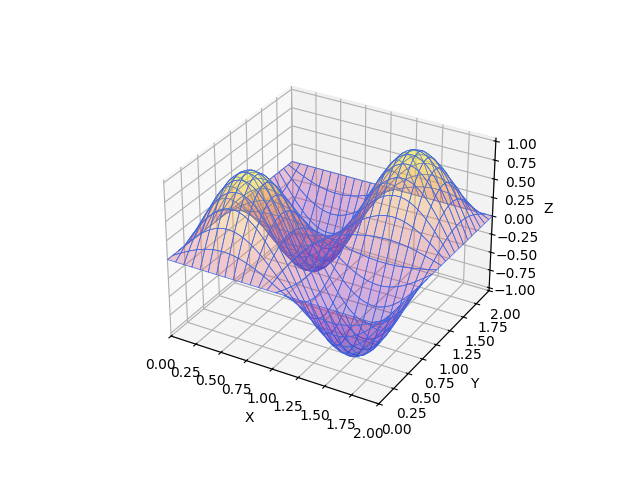

In [12]:
%matplotlib widget

from math import sin, cos, pi
import matplotlib.pyplot as plt
import numpy as np


def f(x, y):
    return -2 * pi ** 2 * np.sin(pi * y) * np.sin(pi * x)
def real_u(x, y):
    return np.sin(pi * x) * np.sin(pi * y)

x, y = np.linspace(0, 2, 200), np.linspace(0, 2, 200)
X, Y = np.meshgrid(x, y)
z = real_u(X, Y)
print(z.shape)
ax = plt.figure().add_subplot(projection="3d")
ax.plot_surface(X, Y, z, edgecolor="royalblue", lw=0.5, rstride=8, cstride=8, alpha=0.3, cmap="plasma")
ax.set(xlim=(0, 2), ylim=(0, 2),
       xlabel='X', ylabel='Y', zlabel='Z')

In [13]:
def get_tensor(x, y):
    return NN((np.column_stack((x, y))))

In [14]:
def ode_system(coord, net):
    x = coord[..., 0]
    y = coord[..., 1]
    x = tf.constant(x, dtype=tf.float32)
    y = tf.constant(y, dtype=tf.float32)
    coord = tf.constant(coord, dtype=tf.float32)
    with tf.GradientTape() as tape_second:
        with tf.GradientTape() as tape_first:
            u = get_tensor(x, y)
            # u = x + y
        grad = tape_first.gradient(u, net.trainable_variables[0])
    grad_grad = tape_second.gradient(grad, net.trainable_variables[0])
    u_x, u_y = grad
    u_xx, u_yy = grad_grad
    # u_y = tape.gradient(u, net.trainable_variables[1])
    # for var, g in zip(net.trainable_variables, grad):
    #     print(f'{var.name}, shape: {g.shape}')
    # [u_x, u_y] = tape.gradient(u, [x, y])
    # print(grad)
    # print(grad_grad)
    # with tf.GradientTape() as tape_second:
    #     tape_second.watch(x)
    #     with tf.GradientTape() as tape_first:
    #         tape_first.watch(x)
    #         u = net(np.column_stack((x, y)))
    #     u_x = tape_first.gradient(u, y)
    #     print(u_x)
    # u_xx = tape_second.gradient(u_x, x)
    ode_loss = u_xx + u_yy - (-2 * pi**2 * tf.math.sin(pi * y) * tf.math.sin(pi * x))
    square_loss = tf.square(ode_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

In [15]:
train_coord = np.linspace((0, 0), (2, 2), 32)
x = train_coord[..., 0].reshape(-1, 1)
y = train_coord[..., 1]
train_loss_record = []

NN.fit([x, y], epochs=100, batch_size=32)

for itr in range(3000):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_coord, NN)
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if itr % 1000 == 0:
        print(train_loss.numpy())

plt.figure(figsize=(10, 8))
plt.plot(train_loss_record)
plt.show()

Epoch 1/100


ValueError: None values not supported.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


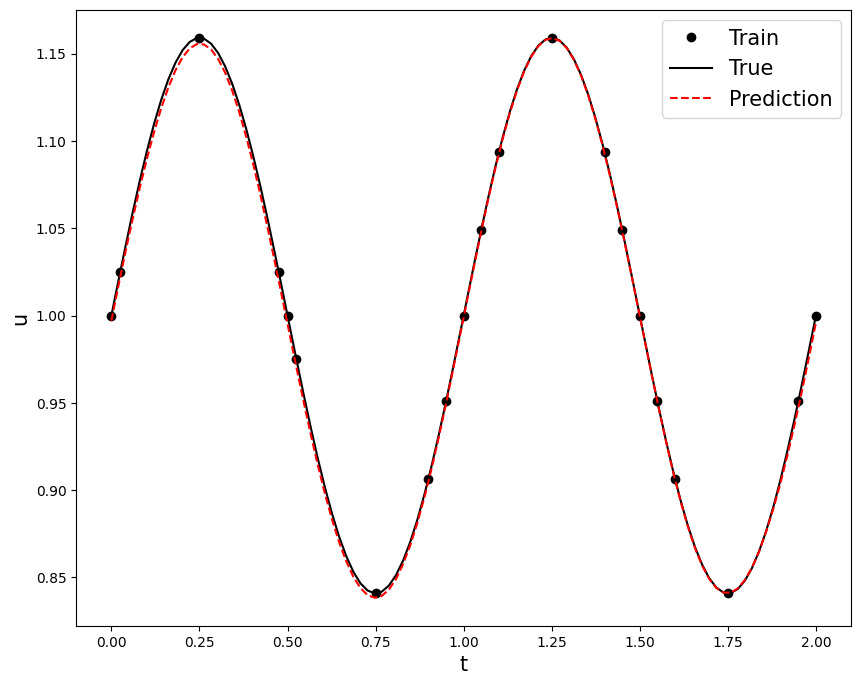

In [ ]:
test_t = np.linspace(0, 2, 100)

train_u = np.sin(2 * np.pi * train_t) / (2 * np.pi) + 1
tr NN.predict(test_coord).ravel()ue_u = np.sin(2 * np.pi * test_t) / (2 * np.pi) + 1
pred_u = NN.predict(test_t).ravel()

plt.figure(figsize=(10, 8))
plt.plot(train_t, train_u, "ok", label="Train")
plt.plot(test_t, true_u, "-k", label="True")
plt.plot(test_t, pred_u, "--r", label="Prediction")
plt.legend(fontsize=15)
plt.xlabel("t", fontsize=15)
plt.ylabel("u", fontsize=15)
plt.show()

[[0.   0.  ]
 [0.   0.01]
 [0.   0.02]
 ...
 [1.99 1.97]
 [1.99 1.98]
 [1.99 1.99]]
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step
[-0.08572379 -0.0828835  -0.08004311 ...  0.86598015  0.8664623
  0.86693746]
[[-0.08572379 -0.0828835  -0.08004311 ...  0.423532    0.42554843
   0.42755717]
 [-0.08124938 -0.07840718 -0.07556498 ...  0.4264649   0.42846942
   0.43046647]
 [-0.07677116 -0.07392707 -0.07108306 ...  0.42939383  0.4313867
   0.43337214]
 ...
 [ 0.57793546  0.5805158   0.5830845  ...  0.8632846   0.8637692
   0.8642471 ]
 [ 0.57956934  0.58214617  0.5847117  ...  0.864637    0.8651203
   0.86559665]
 [ 0.5811876   0.58376086  0.58632326 ...  0.86598015  0.8664623
   0.86693746]]


[(0.0, 2.0),
 (0.0, 2.0),
 Text(0.5, 0, 'X'),
 Text(0.5, 0.5, 'Y'),
 Text(0.5, 0, 'Z')]

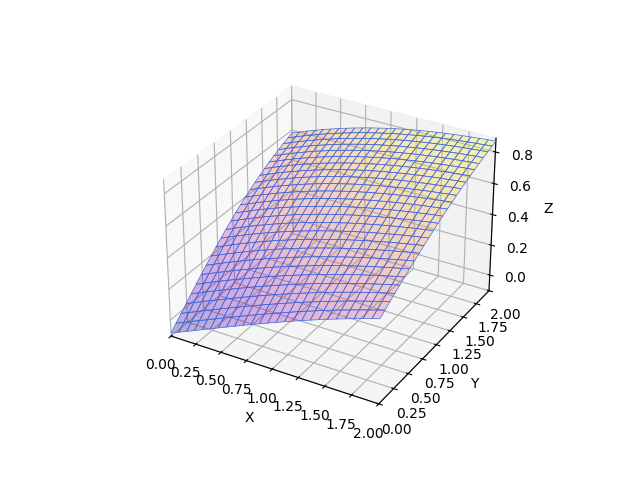

In [ ]:
x, y = np.linspace(0, 2, 200), np.linspace(0, 2, 200)
X, Y = np.meshgrid(x, y)
test_coord = np.mgrid[0:2:0.01, 0:2:0.01].reshape(2, -1).T
print(test_coord)
z = NN.predict(test_coord).ravel()
print(z)
z = z.reshape(200, 200)
print(z)
ax = plt.figure().add_subplot(projection="3d")
ax.plot_surface(
    X,
    Y,
    z,
    edgecolor="royalblue",
    lw=0.5,
    rstride=8,
    cstride=8,
    alpha=0.3,
    cmap="plasma",
)
ax.set(xlim=(0, 2), ylim=(0, 2), xlabel="X", ylabel="Y", zlabel="Z")